In [2]:
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from tensorflow.keras.layers import *
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [3]:
# unzip our data set
shutil.unpack_archive('dataset (1).zip', './data')

In [ ]:
train = []
test = []

# count how many images we have for training and testing
for i in os.listdir('./data/train'):
    train.extend(os.listdir(os.path.join('./data/train', i)))
    test.extend(os.listdir(os.path.join('./data/test', i)))

print('train number: {}, test number: {}'.format(len(train), len(test)))

train number: 10000, test number: 3000


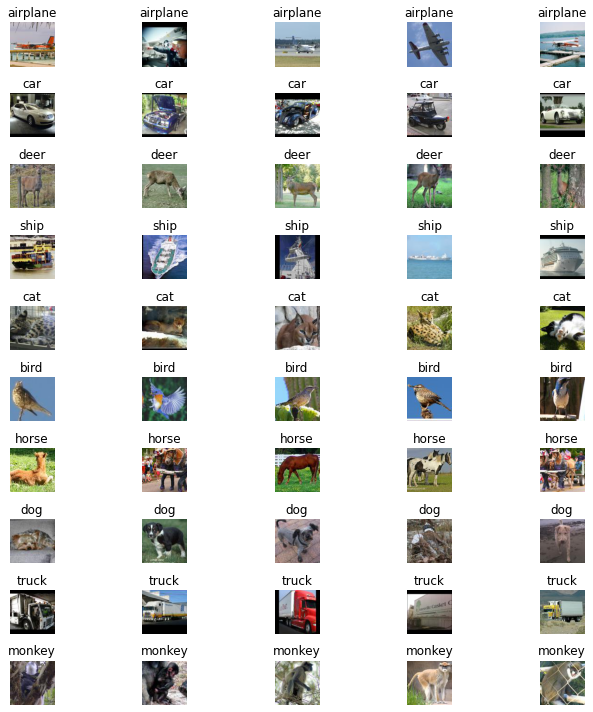

In [ ]:
# show 5 images per class to do sanity check
fig, ax = plt.subplots(10, 5, figsize=(10, 10))
count = 0

for i in os.listdir('./data/train'):
    train_classes = os.listdir(os.path.join('./data/train', i))

    for j in range(5):
        img = os.path.join('./data/train', i, train_classes[j])
        ax[count][j].set_title(i)
        ax[count][j].imshow(PIL.Image.open(img))
        ax[count][j].axis('off')
    count += 1

fig.tight_layout()
plt.show()

In [ ]:
# do image augmentation, with normalization, zooming range and horizontal flip for training data
# and just normalization for testing data

train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('./data/train',
            target_size=(256, 256), batch_size=32,
            class_mode='categorical')

test_generator = train_datagen.flow_from_directory('./data/test',
            target_size=(256, 256), batch_size=32,
            class_mode='categorical')

Found 10000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.


In [4]:
# load inception resnet v2 model
basemodel = InceptionResNetV2(weights='imagenet', include_top=False,
                              input_tensor=Input(shape=(256, 256, 3)))

basemodel.trainable = False

# add our own layers to the model
headmodel = basemodel.output
headmodel = GlobalAveragePooling2D(name='global_average_pool')(headmodel)
headmodel = Flatten(name='flatten')(headmodel)
headmodel = Dense(256, activation='relu', name='dense_1')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation='relu', name='dense_2')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(10, activation='softmax', name='dense_3')(headmodel)

model = Model(inputs=basemodel.input, outputs=headmodel)

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.01, momentum=0.9),
              metrics='accuracy')

earlystopping = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=20)

# save model weights
checkpointer = ModelCheckpoint(filepath='./model/test_task_weights.hdf5', metrics=['accuracy'], verbose=1, save_weights_only=True)

219070464/219055592 [==============================] - 2s 0us/step


If you want to just load model weights and not train it for couple hours, **DO NOT RUN** the cell below

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // 32, epochs=1, callbacks=[checkpointer, earlystopping])

# unfreeze model to do fine tuning with very small learning rate
basemodel.trainable = True

earlystopping_fine = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=20)

# save fine tuned model weights
checkpointer_fine = ModelCheckpoint(filepath='./model/test_task_weights_fine.hdf5', monitor='val_accuracy', verbose=1, save_weights_only=True)

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.0001, momentum=0.9),
              metrics='accuracy')

history_fine = model.fit(train_generator,
                         steps_per_epoch=train_generator.n // 32,
                         epochs=1, callbacks=[checkpointer_fine, earlystopping_fine])

evaluate = model.evaluate_generator(test_generator, steps=test_generator.n // 32, verbose=1)

print('Accuracy Test: {}'.format(evaluate[1]))

312/312 [==============================] - 2867s 9s/step - loss: 0.3634 - accuracy: 0.8892

Epoch 00001: saving model to ./model/test_task_weights.hdf5
  8/312 [..............................] - ETA: 3:15:01 - loss: 0.6217 - accuracy: 0.8438

KeyboardInterrupt: ignored

If you want to just load model weights and not train it for couple hours, **PLEASE RUN** the cell below

In [6]:
model.load_weights('./model/test_task_fine_tune.hdf5')

In [7]:
labels = {0: 'airplane',
          1: 'bird',
          2: 'car',
          3: 'cat',
          4: 'deer',
          5: 'dog',
          6: 'horse',
          7: 'monkey',
          8: 'ship',
          9: 'truck'}

# see our model summary
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Make prediction for the test set

In [43]:
prediction_test = []
image = []
true = []

for i in os.listdir('./data/test'):
    for item in os.listdir(os.path.join('./data/test', i)):
        # code to open the image
        img = PIL.Image.open(os.path.join('./data/test', i, item))
        # resizing image to 256x256
        img = img.resize((256, 256))
        image.append(img)
        # converting image to array
        img = np.asarray(img, dtype=np.float32)
        # normalizing image
        img = img / 255
        # reshaping image to 4D array
        img = img.reshape(-1, 256, 256, 3)
        # add current folder name to the list with true values since it equals to the picture's label
        true.append((i))
        # making prediction
        predict = model.predict(img)
        # getting the index corresponding to the highest value in the prediction
        predict = np.argmax(predict)
        # writing prediction to the list
        prediction_test.append(labels[predict])

Let's plot confusion matrix

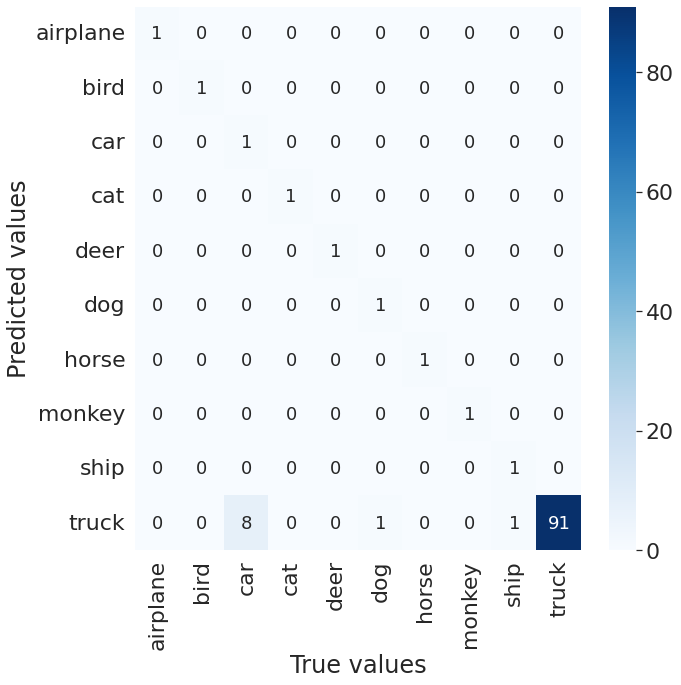

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score
import pandas as pd


cm = confusion_matrix(true, prediction_test)
cm_df = pd.DataFrame(cm, index=labels.values(), columns=labels.values())
plt.figure(figsize=(10, 10))
sns.set(font_scale = 2)
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize":18})
plt.xlabel('True values')
plt.ylabel('Predicted values');

Check accuracy score for the test set

In [45]:
print(accuracy_score(true, prediction_test))

0.9090909090909091


Plot classification report to see the classes that are harder for our model to predict and where precision/recall is less balanced

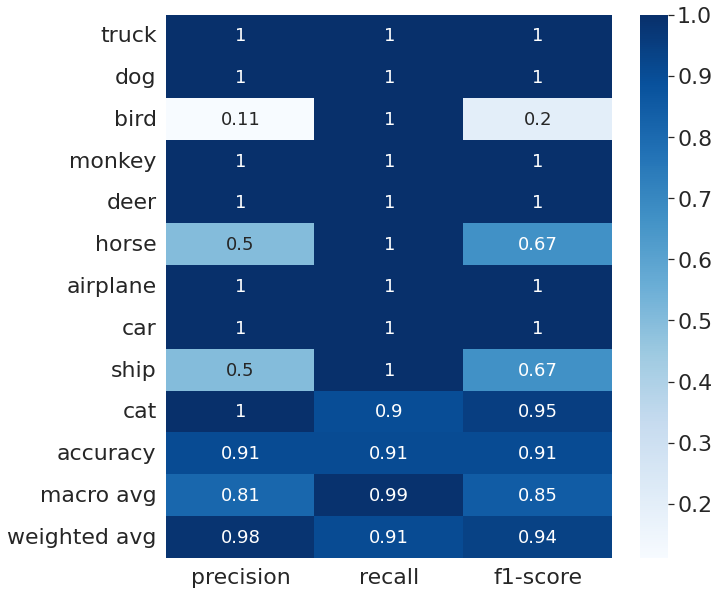

In [46]:
cr = classification_report(true, prediction_test, 
                           target_names=os.listdir('./data/test'),
                           labels=list(labels.values()),
                           output_dict=True)

plt.figure(figsize=(10, 10))
sns.set(font_scale = 2)
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, cmap='Blues', annot_kws={"fontsize":18});

Now let's make prediction for unlabeled data 

In [ ]:
import re


# function to sort pictures names in folder humanly, not like '1, 100, 2, 200, 3...'
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)] 
    return sorted(data, key=alphanum_key)


prediction = {}
image = []

for item in sorted_alphanumeric(os.listdir('./data/unlabeled')):
    # skip if we face with another folder
    if os.path.isdir(os.path.join('./data/unlabeled', item)):
        continue
    
    # code to open the image
    img = PIL.Image.open(os.path.join('./data/unlabeled', item))
    # resizing image to 256x256
    img = img.resize((256, 256))
    image.append(img)
    # converting image to array
    img = np.asarray(img, dtype=np.float32)
    # normalizing image
    img = img / 255
    # reshaping image to 4D array
    img = img.reshape(-1, 256, 256, 3)
    # making prediction
    predict = model.predict(img)
    # getting the index corresponding to the highest value in the prediction
    predict = np.argmax(predict)
    # writing prediction to the vocabulary with picture name
    prediction[item] = labels[predict]

# write predictions to .txt file
f = open('./prediction/prediction.txt', "w")
for i in prediction.keys():
    f.write("'{}':'{}'\n".format(i, prediction[i]))
f.close()

Visualize some random images with corresponding prediction

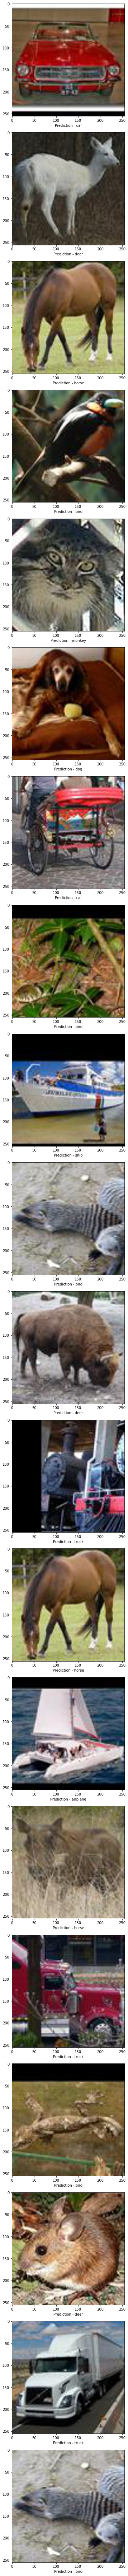

In [ ]:
import random


# check what prediction model makes for unlabeled data
key_list = list(prediction.values())

fig = plt.figure(figsize=(100,100))
for i in range(20):
    j = random.randint(0, len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel('Prediction - ' + key_list[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

As we see, our trained model makes not the best prediction for unlabeled data.
Partly because new classes add (like trains, various animal species and other), model cannot recognize them.

**How can we increase prediction quality and utilize unlabeled data in best way?**

One of the ways to do it is provide Pseudo-Labeling which is Semi-Supervised Learning algorithm (SSL).

The challenge we can face during Semi-Supervised Learning is to find a best way to use the unlabeled data.

To not affect on model weights significantly, we can apply a scheduled weight function Alpha.

Alpha is a coefficient by which we multiply the unlabeled data loss before adding to labeled data loss.

For example, for the first N epochs we train our model on the labeled data and Alpha equals to zero.
But when model retrains on the unlabeled data, we multiply unlabeled data loss by 2.


Keeping it in mind, we can provide SSL, keeping this algorithm:

* Having a classifier trained on the labeled data, and prediction on unlabeled data, we can concatenate training set and randomly sampled part of the prediction on unlabeled set assuming it as pseudo-labels.
* In the next step, we do a model retraining on the concatenated set.
* Then we again merge our data set with the new random part of pseudo-labels and again do a model retraining.
* We repeate these steps until use all of the unlabeled data prediction. 

As shows, for example, [this](https://www.kaggle.com/fl2ooo/nn-wo-pseudo-1-fold-seed) Kaggle work, this approach can lead us to the overall model scoring improvement.